In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

### Load Data

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = "./FRUIT-16K/"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

16000

In [6]:
class_names = dataset.classes
class_names 

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(12000, 4000)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].


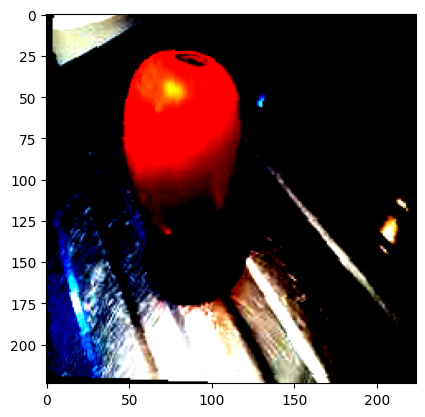

In [11]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

In [12]:
num_classes = len(dataset.classes)
num_classes

16

### CNN

In [13]:
class FruitClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [15]:
# Instantiate the model, loss function, and optimizer
model = FruitClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 2.79
Batch: 20, Epoch: 1, Loss: 2.66
Batch: 30, Epoch: 1, Loss: 2.45
Batch: 40, Epoch: 1, Loss: 2.42
Batch: 50, Epoch: 1, Loss: 1.88
Batch: 60, Epoch: 1, Loss: 1.61
Batch: 70, Epoch: 1, Loss: 1.35
Batch: 80, Epoch: 1, Loss: 1.51
Batch: 90, Epoch: 1, Loss: 1.44
Batch: 100, Epoch: 1, Loss: 1.51
Batch: 110, Epoch: 1, Loss: 1.54
Batch: 120, Epoch: 1, Loss: 1.49
Batch: 130, Epoch: 1, Loss: 1.09
Batch: 140, Epoch: 1, Loss: 1.19
Batch: 150, Epoch: 1, Loss: 1.50
Batch: 160, Epoch: 1, Loss: 1.13
Batch: 170, Epoch: 1, Loss: 0.92
Batch: 180, Epoch: 1, Loss: 0.85
Batch: 190, Epoch: 1, Loss: 0.76
Batch: 200, Epoch: 1, Loss: 1.42
Batch: 210, Epoch: 1, Loss: 1.29
Batch: 220, Epoch: 1, Loss: 1.36
Batch: 230, Epoch: 1, Loss: 0.72
Batch: 240, Epoch: 1, Loss: 0.66
Batch: 250, Epoch: 1, Loss: 0.81
Batch: 260, Epoch: 1, Loss: 0.74
Batch: 270, Epoch: 1, Loss: 0.87
Batch: 280, Epoch: 1, Loss: 0.96
Batch: 290, Epoch: 1, Loss: 0.71
Batch: 300, Epoch: 1, Loss: 0.89
Batch: 310, Epoch: 

### CNN with batch normalization, dropout, regularization

In [15]:
class FruitClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [18]:
model = FruitClassifierCNNWithRegularization(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 9.88
Batch: 20, Epoch: 1, Loss: 2.97
Batch: 30, Epoch: 1, Loss: 2.59
Batch: 40, Epoch: 1, Loss: 2.81
Batch: 50, Epoch: 1, Loss: 2.49
Batch: 60, Epoch: 1, Loss: 2.39
Batch: 70, Epoch: 1, Loss: 2.17
Batch: 80, Epoch: 1, Loss: 2.36
Batch: 90, Epoch: 1, Loss: 2.28
Batch: 100, Epoch: 1, Loss: 2.21
Batch: 110, Epoch: 1, Loss: 2.32
Batch: 120, Epoch: 1, Loss: 2.20
Batch: 130, Epoch: 1, Loss: 2.04
Batch: 140, Epoch: 1, Loss: 1.94
Batch: 150, Epoch: 1, Loss: 1.95
Batch: 160, Epoch: 1, Loss: 2.31
Batch: 170, Epoch: 1, Loss: 2.03
Batch: 180, Epoch: 1, Loss: 2.11
Batch: 190, Epoch: 1, Loss: 2.30
Batch: 200, Epoch: 1, Loss: 2.10
Batch: 210, Epoch: 1, Loss: 1.94
Batch: 220, Epoch: 1, Loss: 1.67
Batch: 230, Epoch: 1, Loss: 1.84
Batch: 240, Epoch: 1, Loss: 2.10
Batch: 250, Epoch: 1, Loss: 1.88
Batch: 260, Epoch: 1, Loss: 2.11
Batch: 270, Epoch: 1, Loss: 1.96
Batch: 280, Epoch: 1, Loss: 2.41
Batch: 290, Epoch: 1, Loss: 2.08
Batch: 300, Epoch: 1, Loss: 2.05
Batch: 310, Epoch: 

### No regularization

In [18]:
# Instantiate the model, loss function, and optimizer
model = FruitClassifierCNNWithRegularization(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 10.50
Batch: 20, Epoch: 1, Loss: 3.12
Batch: 30, Epoch: 1, Loss: 2.68
Batch: 40, Epoch: 1, Loss: 2.41
Batch: 50, Epoch: 1, Loss: 2.59
Batch: 60, Epoch: 1, Loss: 2.35
Batch: 70, Epoch: 1, Loss: 2.24
Batch: 80, Epoch: 1, Loss: 2.13
Batch: 90, Epoch: 1, Loss: 2.09
Batch: 100, Epoch: 1, Loss: 2.12
Batch: 110, Epoch: 1, Loss: 2.69
Batch: 120, Epoch: 1, Loss: 1.91
Batch: 130, Epoch: 1, Loss: 2.31
Batch: 140, Epoch: 1, Loss: 2.54
Batch: 150, Epoch: 1, Loss: 2.18
Batch: 160, Epoch: 1, Loss: 2.05
Batch: 170, Epoch: 1, Loss: 1.99
Batch: 180, Epoch: 1, Loss: 2.00
Batch: 190, Epoch: 1, Loss: 2.09
Batch: 200, Epoch: 1, Loss: 1.99
Batch: 210, Epoch: 1, Loss: 2.11
Batch: 220, Epoch: 1, Loss: 2.20
Batch: 230, Epoch: 1, Loss: 2.00
Batch: 240, Epoch: 1, Loss: 2.28
Batch: 250, Epoch: 1, Loss: 1.65
Batch: 260, Epoch: 1, Loss: 1.77
Batch: 270, Epoch: 1, Loss: 1.87
Batch: 280, Epoch: 1, Loss: 2.31
Batch: 290, Epoch: 1, Loss: 2.48
Batch: 300, Epoch: 1, Loss: 1.96
Batch: 310, Epoch:

In [19]:
# Instantiate the model, loss function, and optimizer
model = FruitClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 2.76
Batch: 20, Epoch: 1, Loss: 2.57
Batch: 30, Epoch: 1, Loss: 2.53
Batch: 40, Epoch: 1, Loss: 2.16
Batch: 50, Epoch: 1, Loss: 2.38
Batch: 60, Epoch: 1, Loss: 1.79
Batch: 70, Epoch: 1, Loss: 1.67
Batch: 80, Epoch: 1, Loss: 1.45
Batch: 90, Epoch: 1, Loss: 1.39
Batch: 100, Epoch: 1, Loss: 1.17
Batch: 110, Epoch: 1, Loss: 1.06
Batch: 120, Epoch: 1, Loss: 1.26
Batch: 130, Epoch: 1, Loss: 1.03
Batch: 140, Epoch: 1, Loss: 1.19
Batch: 150, Epoch: 1, Loss: 1.36
Batch: 160, Epoch: 1, Loss: 0.81
Batch: 170, Epoch: 1, Loss: 1.22
Batch: 180, Epoch: 1, Loss: 1.14
Batch: 190, Epoch: 1, Loss: 0.94
Batch: 200, Epoch: 1, Loss: 1.14
Batch: 210, Epoch: 1, Loss: 0.76
Batch: 220, Epoch: 1, Loss: 1.38
Batch: 230, Epoch: 1, Loss: 1.08
Batch: 240, Epoch: 1, Loss: 0.87
Batch: 250, Epoch: 1, Loss: 0.81
Batch: 260, Epoch: 1, Loss: 0.81
Batch: 270, Epoch: 1, Loss: 0.83
Batch: 280, Epoch: 1, Loss: 0.93
Batch: 290, Epoch: 1, Loss: 0.69
Batch: 300, Epoch: 1, Loss: 0.69
Batch: 310, Epoch: 

In [20]:
torch.save(model.state_dict(), 'saved_model.pth')